In [64]:
import numpy as np
import xarray as xr
import rioxarray
import sqlite3
from pathlib import Path
from datetime import datetime
from frost_filter import frost_wrapper
from scipy.ndimage import uniform_filter
from scipy.ndimage import variance
import matplotlib.pyplot as plt
from skimage.filters import threshold_minimum

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
base_folder = Path("/home/ebiederstadt/Documents_sync/sentinel_cache/bbox-111.9392593_56.936104843_-111.6770842_57.023933326")

con = sqlite3.connect(base_folder.joinpath("approximation.db"))
cur = con.cursor()

In [3]:
# It seems like it is better for ou analysis to have data combined into single tiffs per date

res = cur.execute("SELECT year, month, day from sentinel1 order by year, month, day")
dates = res.fetchall()

for date in dates:
    year, month, day = date
    path = base_folder.joinpath(f"{year}-{month:02}-{day:02}")

    # tiff = rasterio.open(path.joinpath("VV.tif"))
    # vv = tiff.read(1)

    # vh = rasterio.open(path.joinpath("VH.tif")).read(1)

    # with rasterio.open(
    #     path.joinpath("combined.tif"),
    #     "w+",
    #     "GTiff",
    #     vv.shape[1],
    #     vv.shape[0],
    #     2,
    #     tiff.crs,
    #     tiff.transform,
    #     np.float64
    # ) as out:
    #     out.write(vv, 1)
    #     out.write(vh, 2)

    # tiff.close()

    # print(f"Finished {date}")

In [4]:
tiff_paths = []
python_dates = []
for date in dates:
    year, month, day = date
    path = base_folder.joinpath(f"{year}-{month:02}-{day:02}")
    tiff_paths.append(path.joinpath("combined.tif"))
    python_dates.append(datetime(int(year), int(month), int(day)))


python_dates

[datetime.datetime(2019, 1, 4, 0, 0),
 datetime.datetime(2019, 1, 11, 0, 0),
 datetime.datetime(2019, 1, 16, 0, 0),
 datetime.datetime(2019, 1, 23, 0, 0),
 datetime.datetime(2019, 1, 28, 0, 0),
 datetime.datetime(2019, 2, 4, 0, 0),
 datetime.datetime(2019, 2, 9, 0, 0),
 datetime.datetime(2019, 2, 16, 0, 0),
 datetime.datetime(2019, 2, 21, 0, 0),
 datetime.datetime(2019, 3, 5, 0, 0),
 datetime.datetime(2019, 3, 12, 0, 0),
 datetime.datetime(2019, 3, 17, 0, 0),
 datetime.datetime(2019, 3, 24, 0, 0),
 datetime.datetime(2019, 3, 29, 0, 0),
 datetime.datetime(2019, 4, 5, 0, 0),
 datetime.datetime(2019, 4, 10, 0, 0),
 datetime.datetime(2019, 4, 17, 0, 0),
 datetime.datetime(2019, 4, 22, 0, 0),
 datetime.datetime(2019, 4, 29, 0, 0),
 datetime.datetime(2019, 5, 4, 0, 0),
 datetime.datetime(2019, 5, 11, 0, 0),
 datetime.datetime(2019, 5, 16, 0, 0),
 datetime.datetime(2019, 5, 17, 0, 0),
 datetime.datetime(2019, 5, 23, 0, 0),
 datetime.datetime(2019, 5, 28, 0, 0),
 datetime.datetime(2019, 5, 29,

In [5]:
def produce_dataset(dates, tiff_paths):
    """Produce an x-array dataset from a list of dates and tiff paths"""

    time_var = xr.Variable("time", dates)

    geotiffs_da = xr.concat([rioxarray.open_rasterio(i) for i in tiff_paths], dim=time_var)

    # Covert our xarray.DataArray into a xarray.Dataset
    geotiffs_ds = geotiffs_da.to_dataset('band')

    # Rename the variable to a more useful name
    geotiffs_ds = geotiffs_ds.rename({1: 'vv', 2: "vh"})

    return geotiffs_ds

dataset = produce_dataset(python_dates, tiff_paths)
dataset

<xarray.Dataset>
Dimensions:      (time: 79, y: 959, x: 1605)
Coordinates:
  * x            (x) float64 -111.9 -111.9 -111.9 ... -111.7 -111.7 -111.7
  * y            (y) float64 57.02 57.02 57.02 57.02 ... 56.94 56.94 56.94 56.94
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2019-01-04 2019-01-11 ... 2019-12-30
Data variables:
    vv           (time, y, x) float64 10.0 5.0 25.0 32.0 ... 12.0 14.0 7.0 8.0
    vh           (time, y, x) float64 2.0 5.0 5.0 5.0 7.0 ... 2.0 3.0 3.0 2.0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
#defining a function to apply lee filtering on dataset image
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)

    return img_output

In [60]:
valid = np.isfinite(dataset)
dataset = dataset.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
dataset["lee_filter_vv"] = dataset.vv.groupby("time").map(lee_filter, size=7)
dataset["lee_filter_vh"] = dataset.vh.groupby("time").map(lee_filter, size=7)

# Null pixels should remain null
dataset['lee_filter_vv'] = dataset.lee_filter_vv.where(valid.vv)
dataset['lee_filter_vh'] = dataset.lee_filter_vh.where(valid.vh)

In [8]:
# TODO: Try to convert to db?

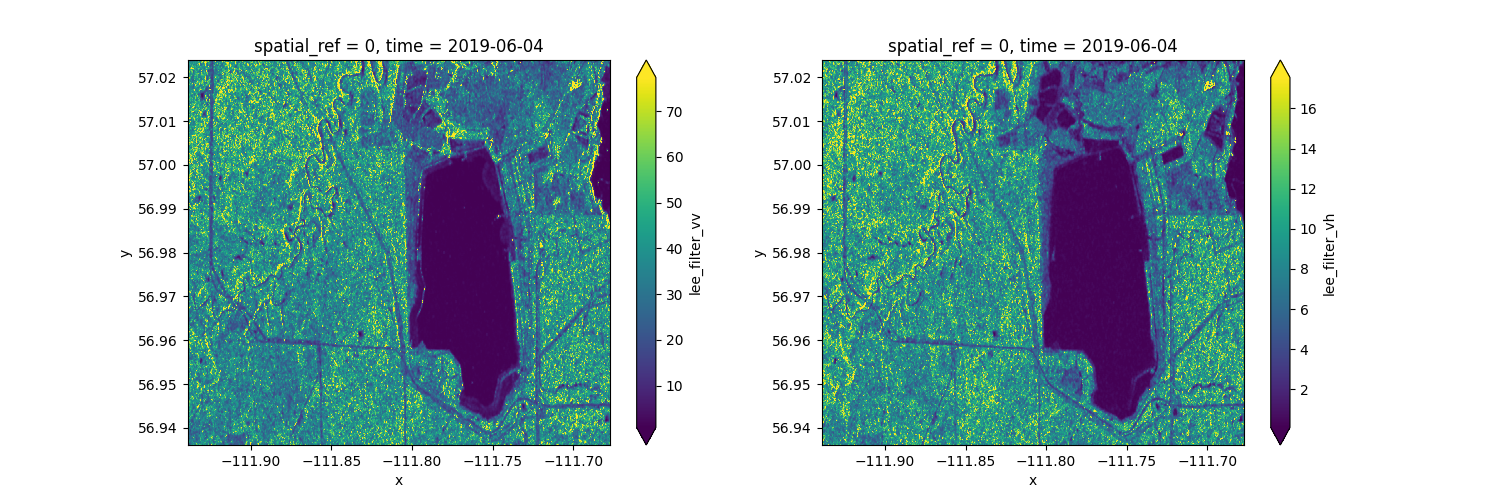

In [59]:
# Plot the first date in June, so that we don't get any strange results with snow interfering
seasonal_data = dataset.sel(time=dataset['time.month'] == 6)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
seasonal_data["lee_filter_vv"].isel(time=0).plot(ax = ax[0], cmap="viridis", robust=True)
seasonal_data["lee_filter_vh"].isel(time=0).plot(ax = ax[1], cmap="viridis", robust=True)
plt.show()

Text(0.5, 1.0, 'Comparison of Lee filtered VH and VV polarisation bands')

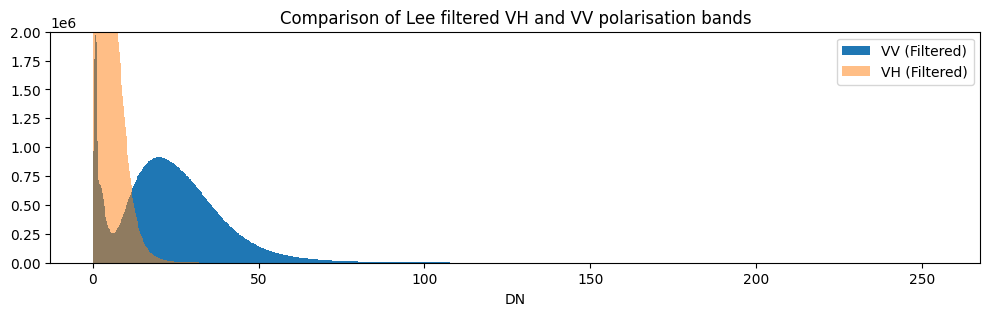

In [10]:
fig = plt.figure(figsize=(12, 3))
dataset.lee_filter_vv.plot.hist(bins=1000, label="VV (Filtered)")
dataset.lee_filter_vh.plot.hist(bins=1000, label="VH (Filtered)",alpha=0.5)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 2e6)
plt.title("Comparison of Lee filtered VH and VV polarisation bands")

In [11]:
# Now, we can try and do the same thing, but using the frost filter to avoid removing noise

valid = np.isfinite(dataset)
dataset = dataset.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
dataset["frost_filter_vv"] = dataset.vv.groupby("time").map(frost_wrapper, win_size=7, damping_factor=3.0)
dataset["frost_filter_vh"] = dataset.vh.groupby("time").map(frost_wrapper, win_size=7, damping_factor=3.0)

# Null pixels should remain null
dataset['frost_filter_vv'] = dataset.frost_filter_vv.where(valid.vv)
dataset['frost_filter_vh'] = dataset.frost_filter_vh.where(valid.vh)

Execution time: 1.37
Execution time: 1.22
Execution time: 1.23
Execution time: 1.21
Execution time: 1.20
Execution time: 1.21
Execution time: 1.22
Execution time: 1.24
Execution time: 1.23
Execution time: 1.10
Execution time: 1.29
Execution time: 1.32
Execution time: 1.20
Execution time: 1.22
Execution time: 1.23
Execution time: 1.18
Execution time: 1.20
Execution time: 1.22
Execution time: 1.22
Execution time: 1.23
Execution time: 1.24
Execution time: 1.19
Execution time: 1.21
Execution time: 1.20
Execution time: 1.26
Execution time: 1.27
Execution time: 1.30
Execution time: 1.29
Execution time: 1.26
Execution time: 1.25
Execution time: 1.26
Execution time: 1.21
Execution time: 1.21
Execution time: 1.25
Execution time: 1.26
Execution time: 1.27
Execution time: 1.25
Execution time: 1.23
Execution time: 1.22
Execution time: 1.20
Execution time: 1.20
Execution time: 1.20
Execution time: 1.22
Execution time: 1.20
Execution time: 1.21
Execution time: 1.21
Execution time: 1.20
Execution tim

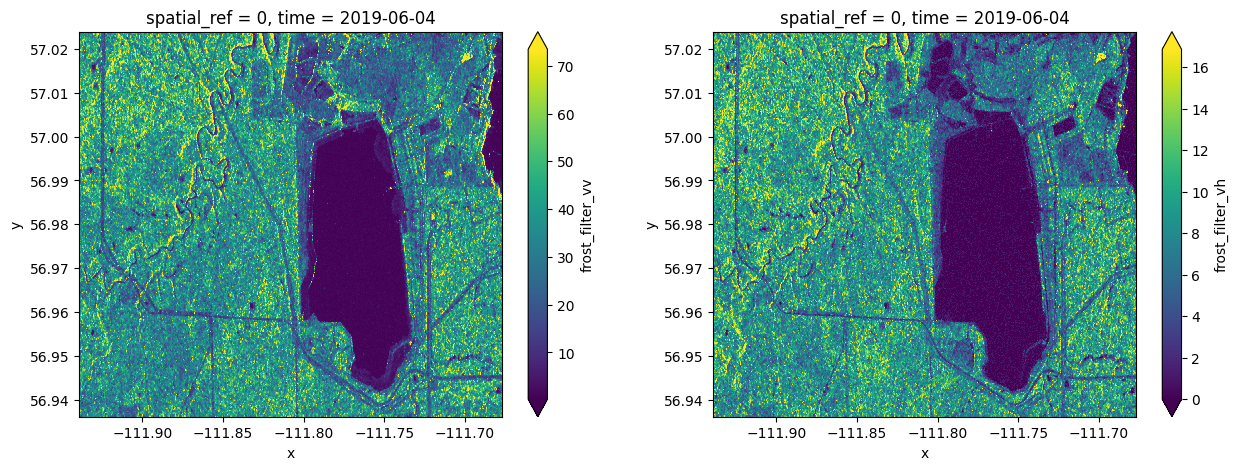

In [12]:
# Plot the first date in June, so that we don't get any strange results with snow interfering
seasonal_data = dataset.sel(time=dataset['time.month'] == 6)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
seasonal_data["frost_filter_vv"].isel(time=0).plot(ax = ax[0], cmap="viridis", robust=True)
seasonal_data["frost_filter_vh"].isel(time=0).plot(ax = ax[1], cmap="viridis", robust=True)

Text(0.5, 1.0, 'Comparison of Frost & Lee filtered VV polarisation bands')

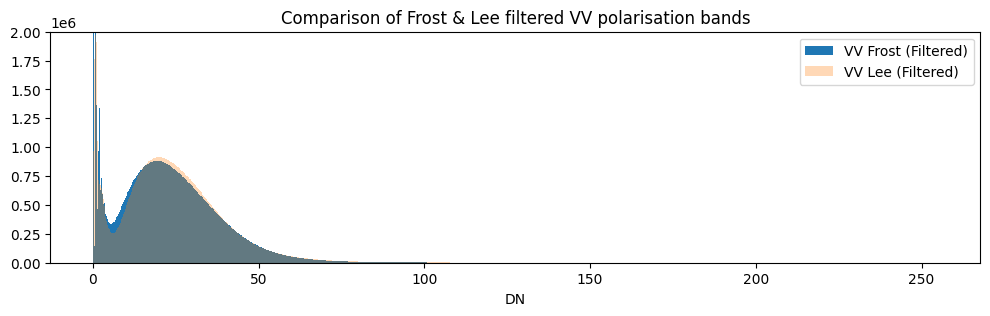

In [13]:
fig = plt.figure(figsize=(12, 3))
dataset.frost_filter_vv.plot.hist(bins=1000, label="VV Frost (Filtered)")
dataset.lee_filter_vv.plot.hist(bins=1000, label="VV Lee (Filtered)", alpha=0.3)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 2e6)
plt.title("Comparison of Frost & Lee filtered VV polarisation bands")

Text(0.5, 1.0, 'Comparison of Frost & Lee filtered VV polarisation bands')

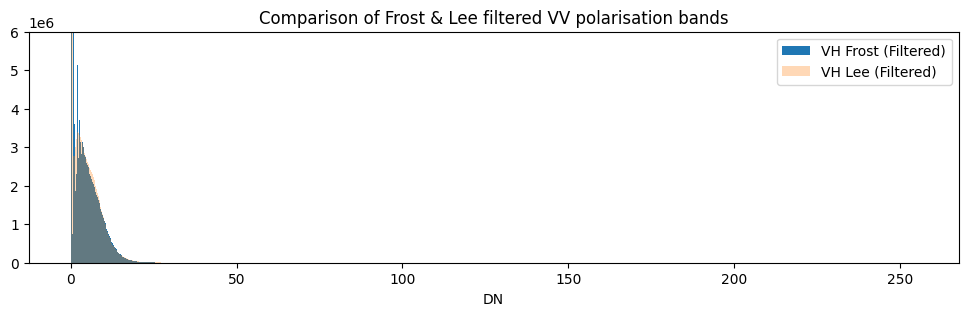

In [27]:
fig = plt.figure(figsize=(12, 3))
dataset.frost_filter_vh.plot.hist(bins=1000, label="VH Frost (Filtered)")
dataset.lee_filter_vh.plot.hist(bins=1000, label="VH Lee (Filtered)", alpha=0.3)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 6e6)
plt.title("Comparison of Frost & Lee filtered VV polarization bands")

Text(0.5, 1.0, 'Comparison of Frost filtered VH and VV polarization bands')

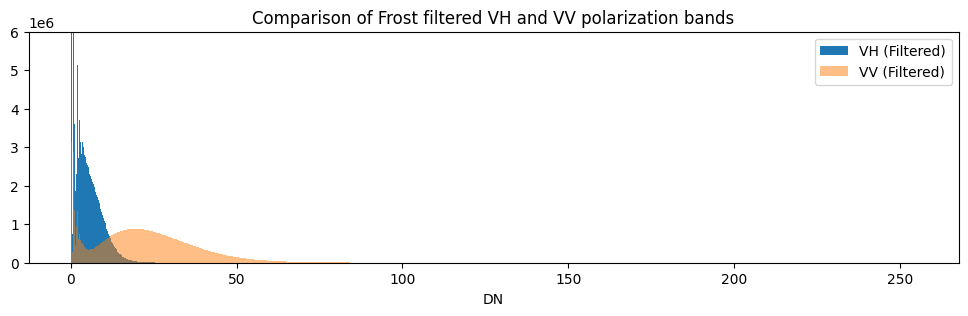

In [29]:
fig = plt.figure(figsize=(12, 3))
dataset.frost_filter_vh.plot.hist(bins=1000, label="VH (Filtered)")
dataset.frost_filter_vv.plot.hist(bins=1000, label="VV (Filtered)", alpha=0.5)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 6e6)
plt.title("Comparison of Frost filtered VH and VV polarization bands")

In [16]:
# Threshold using the minium technique
threshold_frost = threshold_minimum(dataset.frost_filter_vv.values)

threshold_lee = threshold_minimum(dataset.lee_filter_vv.values)

print(f"VV thresholds are {threshold_frost} (Frost) and {threshold_lee} (Lee)")

VV thresholds are 6.474609375 (Frost) and 7.449595060764695 (Lee)


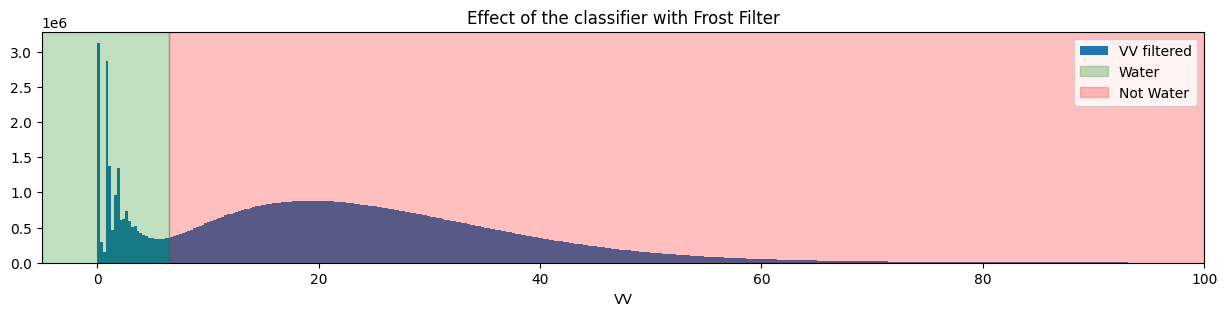

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
dataset.frost_filter_vv.plot.hist(bins=1000, label="VV filtered")
ax.axvspan(xmin=-5, xmax=threshold_frost, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_frost,
           xmax=100,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlim(-5, 100)
plt.xlabel("VV")
plt.title("Effect of the classifier with Frost Filter")
plt.show()

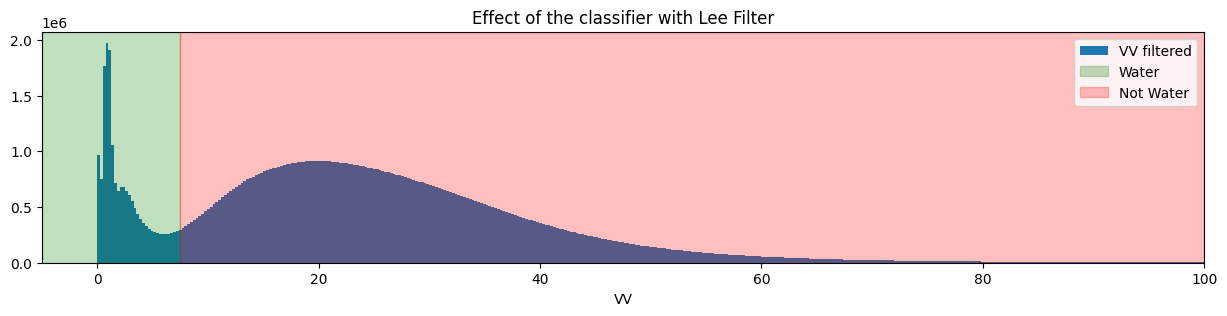

In [18]:
fig, ax = plt.subplots(figsize=(15, 3))
dataset.lee_filter_vv.plot.hist(bins=1000, label="VV filtered")
ax.axvspan(xmin=-5, xmax=threshold_lee, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_lee,
           xmax=100,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlim(-5, 100)
plt.xlabel("VV")
plt.title("Effect of the classifier with Lee Filter")
plt.show()

In [19]:
# Classify the dataset

def S1_water_classifier(da, threshold):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

dataset['water_lee'] = S1_water_classifier(dataset.lee_filter_vv, threshold_lee).s1_water
dataset["water_frost"] = S1_water_classifier(dataset.frost_filter_vv, threshold_frost).s1_water

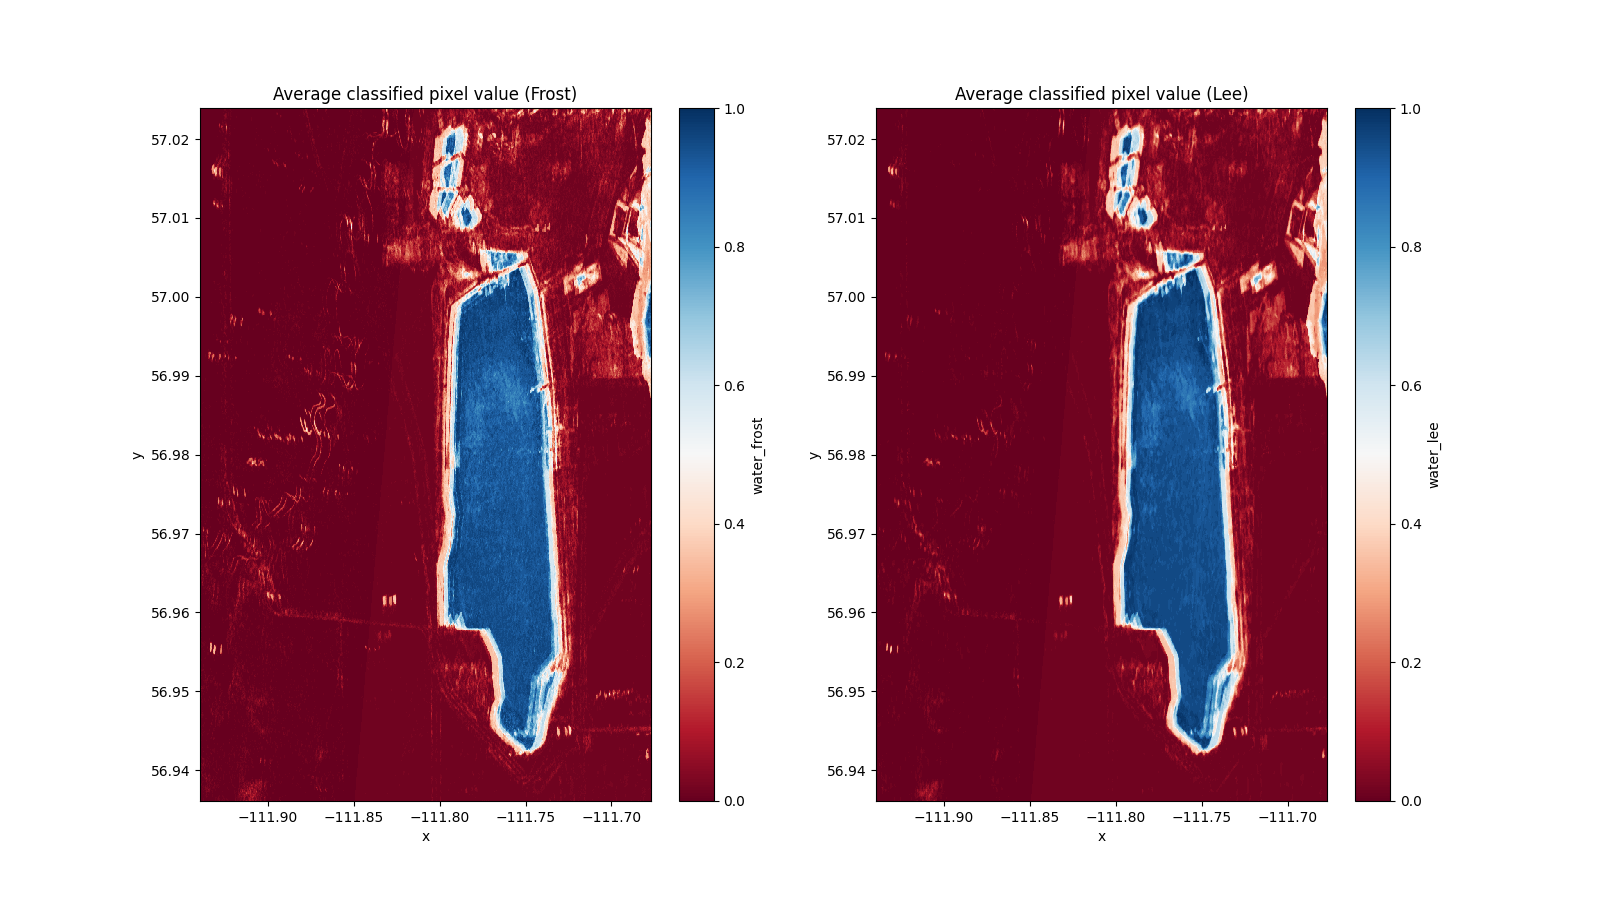

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
dataset.water_frost.mean(dim='time').plot(ax=ax[0], cmap="RdBu")
dataset.water_lee.mean(dim="time").plot(ax=ax[1], cmap="RdBu")
ax[0].set_title("Average classified pixel value (Frost)")
ax[1].set_title("Average classified pixel value (Lee)")
plt.show()

Text(0.5, 1.0, 'Average classified pixel value')

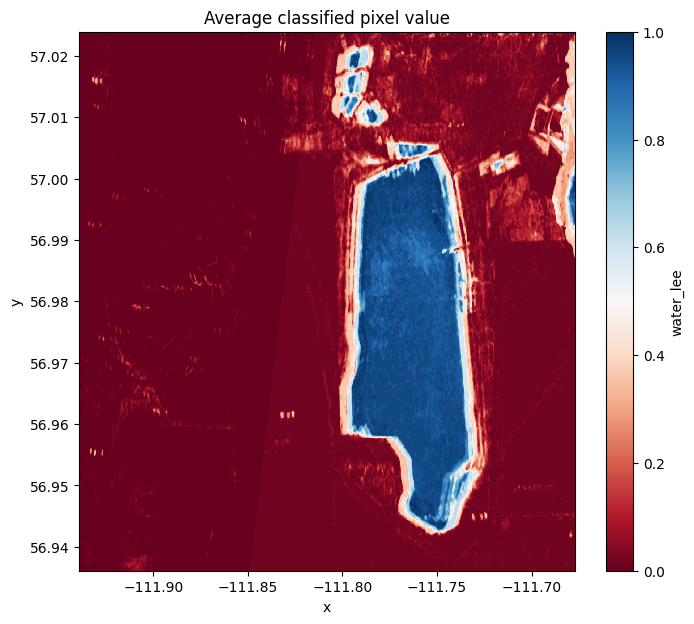

In [21]:
plt.figure(figsize=(8, 7))
dataset.water_lee.mean(dim='time').plot(cmap="RdBu")
plt.title("Average classified pixel value")

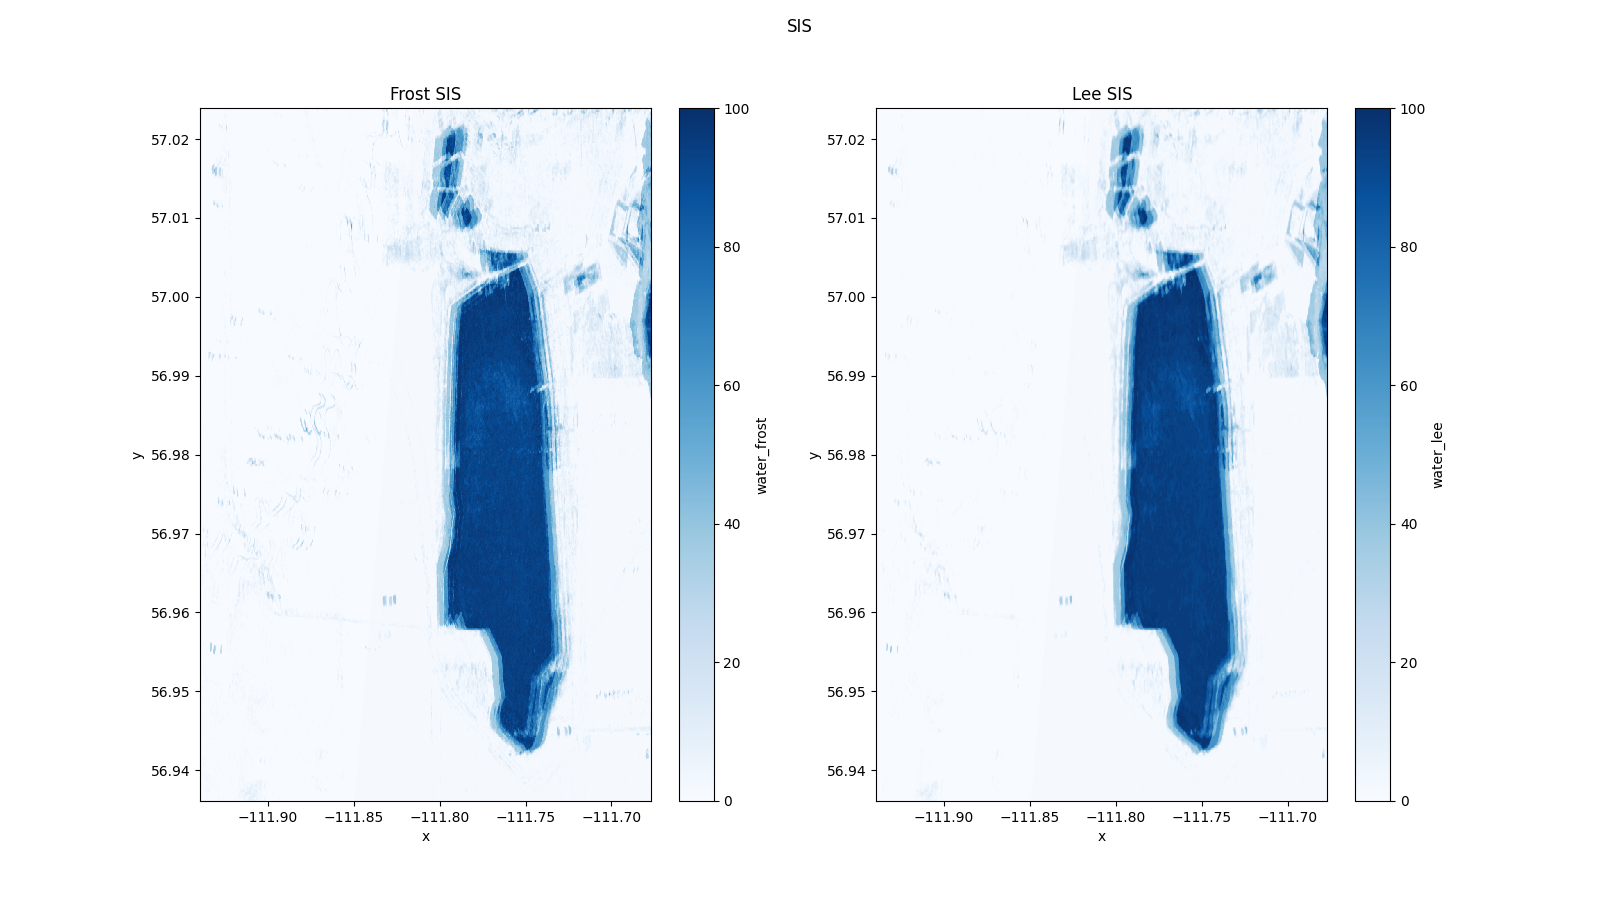

In [50]:
# Single Image Summary
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sis = (dataset.water_frost.sum(dim='time') / dataset.water_frost.time.size) * 100
sis_lee = (dataset.water_lee.sum(dim="time") / dataset.water_lee.time.size) * 100
sis.plot(ax=ax[0], cmap="Blues")
sis_lee.plot(ax=ax[1], cmap="Blues")
ax[0].set_title("Frost SIS")
ax[1].set_title("Lee SIS")

plt.suptitle("SIS")
plt.show()

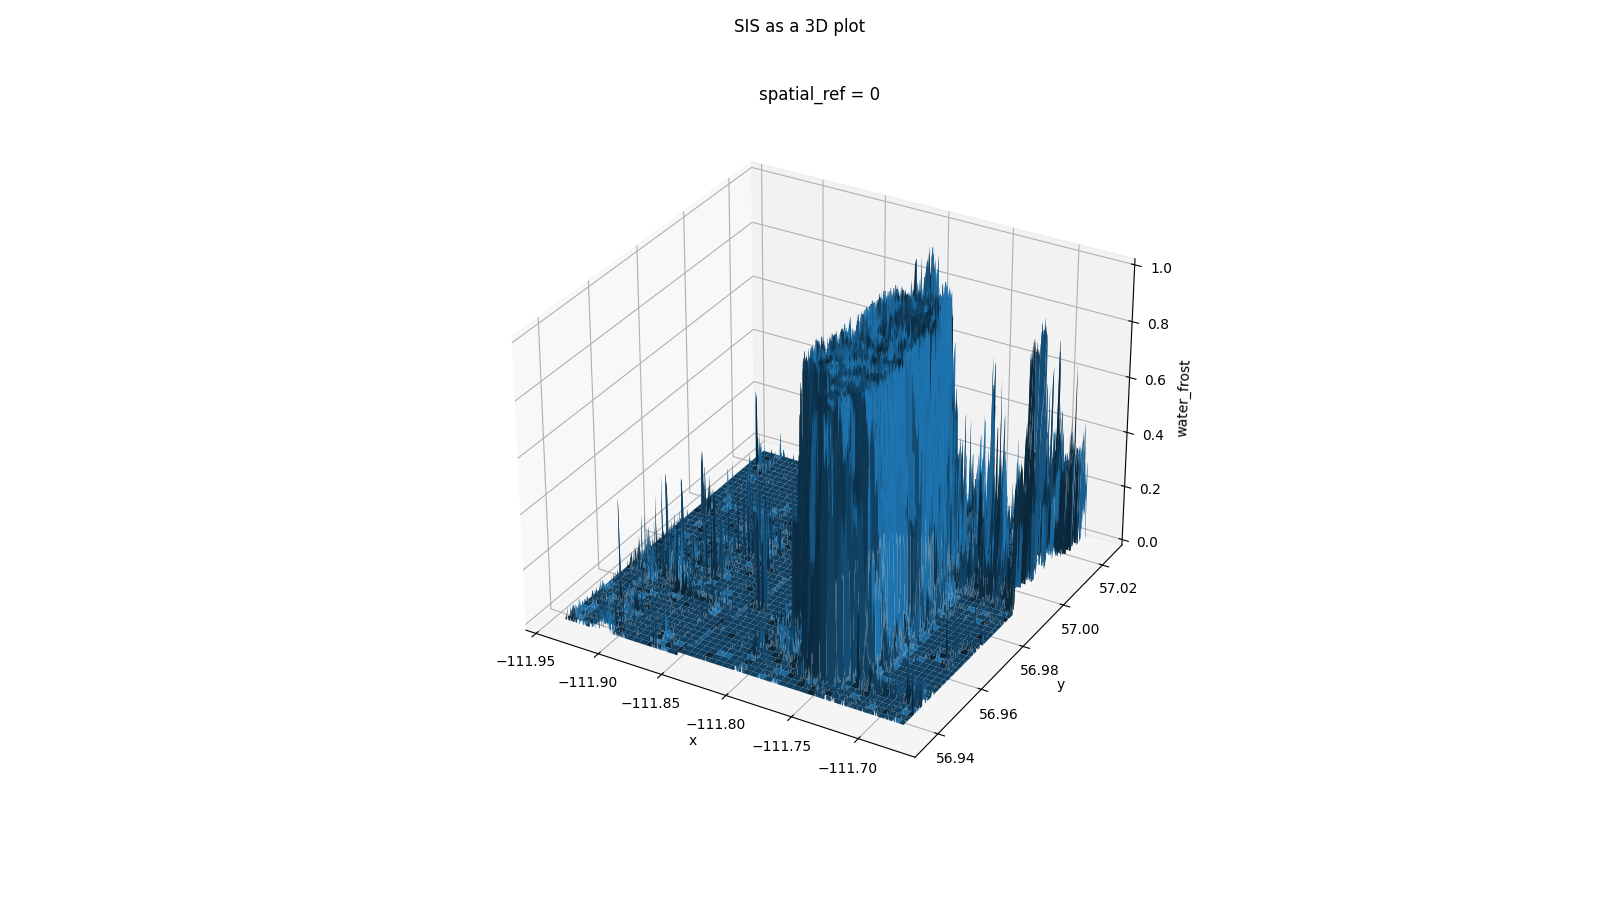

In [33]:
fig = plt.figure(figsize=(16, 9), dpi=100)
sis.plot.surface()
fig.suptitle("SIS as a 3D plot")
plt.show()

In [63]:
# What if we try to limit the analysis to just "summer months"
# Where summer is defined as from May (month 5) to september (month 9)

summer_data = dataset.sel(time=slice('2019-05', '2019-09'))

valid = np.isfinite(summer_data)
summer_data = summer_data.where(valid, 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
summer_data["frost_filter_vv"] = summer_data.vv.groupby("time").map(frost_wrapper, win_size=7, damping_factor=3.0)
summer_data["frost_filter_vh"] = summer_data.vh.groupby("time").map(frost_wrapper, win_size=7, damping_factor=3.0)

# Null pixels should remain null
valid['frost_filter_vv'] = summer_data.frost_filter_vv.where(valid.vv)
summer_data['frost_filter_vh'] = summer_data.frost_filter_vh.where(valid.vh)

summer_data

Execution time: 1.24
Execution time: 1.22
Execution time: 1.22
Execution time: 1.24
Execution time: 1.36
Execution time: 1.26
Execution time: 1.30
Execution time: 1.25
Execution time: 1.25
Execution time: 1.31
Execution time: 1.22
Execution time: 1.23
Execution time: 1.21
Execution time: 1.22
Execution time: 1.21
Execution time: 1.22
Execution time: 1.20
Execution time: 1.21
Execution time: 1.20
Execution time: 1.20
Execution time: 1.21
Execution time: 1.25
Execution time: 1.23
Execution time: 1.21
Execution time: 1.22
Execution time: 1.23
Execution time: 1.23
Execution time: 1.23
Execution time: 1.25
Execution time: 1.25
Execution time: 1.26
Execution time: 1.26
Execution time: 1.25
Execution time: 1.24
Execution time: 1.25
Execution time: 1.25
Execution time: 1.24
Execution time: 1.26
Execution time: 1.25
Execution time: 1.25
Execution time: 1.29
Execution time: 1.34
Execution time: 1.37
Execution time: 1.42
Execution time: 1.24
Execution time: 1.23
Execution time: 1.23
Execution tim

<xarray.Dataset>
Dimensions:          (time: 37, y: 959, x: 1605)
Coordinates:
  * x                (x) float64 -111.9 -111.9 -111.9 ... -111.7 -111.7 -111.7
  * y                (y) float64 57.02 57.02 57.02 57.02 ... 56.94 56.94 56.94
    spatial_ref      int64 0
  * time             (time) datetime64[ns] 2019-05-04 2019-05-11 ... 2019-09-26
Data variables:
    vv               (time, y, x) float64 43.0 38.0 17.0 17.0 ... 10.0 14.0 29.0
    vh               (time, y, x) float64 1.0 3.0 3.0 3.0 ... 7.0 4.0 6.0 9.0
    lee_filter_vv    (time, y, x) float64 36.3 36.31 29.38 ... 21.53 21.19 23.39
    lee_filter_vh    (time, y, x) float64 4.081 4.521 4.231 ... 5.278 6.08 6.765
    frost_filter_vv  (time, y, x) float64 38.77 30.01 29.15 ... 19.44 19.53
    frost_filter_vh  (time, y, x) float64 4.557 4.15 4.177 ... 3.02 6.27 6.469
    water_lee        (time, y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    water_frost      (time, y, x) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Text(0.5, 1.0, 'Comparison of Frost filtered VH and VV polarization bands')

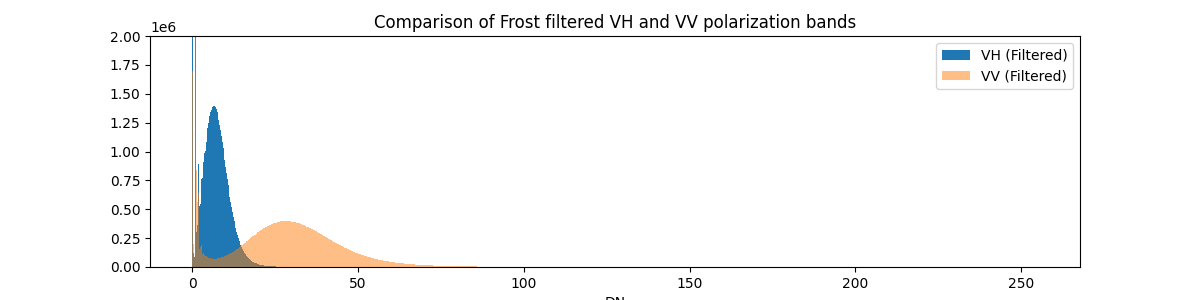

In [92]:
# print a histogram for the data

fig = plt.figure(figsize=(12, 3))
summer_data.frost_filter_vh.plot.hist(bins=1000, label="VH (Filtered)")
summer_data.frost_filter_vv.plot.hist(bins=1000, label="VV (Filtered)", alpha=0.5)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 2e6)
plt.title("Comparison of Frost filtered VH and VV polarization bands")

In [86]:
# Number of pixels equal to 0

summer_data["frost_filter_vv"] = summer_data.frost_filter_vv + 0.0001
summer_data["frost_filter_vh"] = summer_data.frost_filter_vh + 0.0001

VH has 0 0's, and VV has 0 0's


In [95]:
# How many measurements are zero?

vv_sum = (dataset.vv == 0).sum().values
vh_sum = (dataset.vh == 0).sum().values
print(f" VV has {vv_sum} 0's ({(vv_sum / dataset.vv.count()) * 100:.2f}%), and VH has {vh_sum / dataset.vh.count() * 100:.2f}% 0's")

 VV has 3767681 0's (3.10%), and VH has 15.31% 0's


Text(0.5, 1.0, 'Comparison of Frost filtered VH and VV polarization bands')

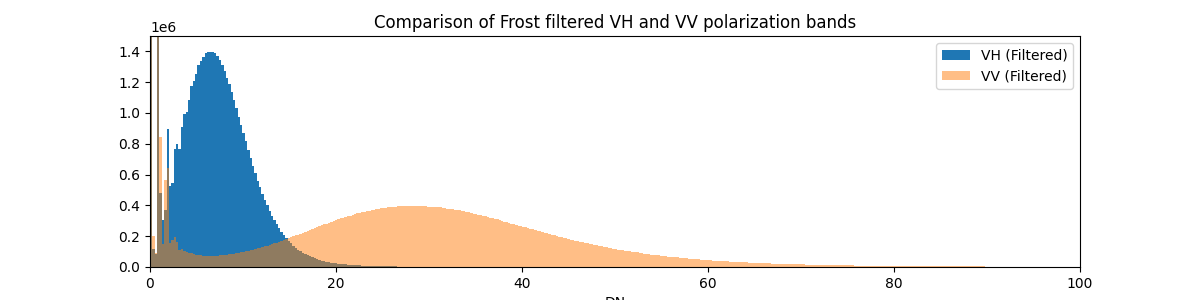

In [89]:
fig = plt.figure(figsize=(12, 3))
summer_data.frost_filter_vh.plot.hist(bins=1000, label="VH (Filtered)")
summer_data.frost_filter_vv.plot.hist(bins=1000, label="VV (Filtered)", alpha=0.5)
plt.legend()
plt.xlabel("DN")
plt.ylim(0, 1.5e6)
plt.xlim(0, 100)
plt.title("Comparison of Frost filtered VH and VV polarization bands")